In [1]:
from pynq import Overlay
overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/LOG_TEST.bit')

In [2]:
import time
import matplotlib.pyplot as plt
from pynq import allocate
import pynq.lib.dma
import numpy as np

In [3]:
from pynq import Clocks

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 62.500000MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


In [22]:
Clocks.fclk0_mhz = 166

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 166.666667MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


In [7]:
lut_dma = overlay.LUT_DMA
te_dma  = overlay.TE_DMA

### Paths

In [6]:
import os

USER_PATH = os.getcwd()
SAVE_PATH = USER_PATH + "/Plots/"

### Settings

In [7]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

## Taylor expansion

## Programmable logic

In [5]:
n = 2**20
print('%d samples' % n)
input_buffer = allocate(shape=(n,), dtype=np.uint64)
output_buffer= allocate(shape=(n,), dtype=np.uint16)

1048576 samples


In [7]:
# generate the inputs
input_value = np.random.randint(1,2**63-1,n, dtype=np.uint64)
#input_value = np.ones(n)*980224589148123649
# convert into int64
input_value = input_value.astype(np.uint64)
# load to the input buffer
np.copyto(input_buffer,input_value)

##  Computation time

In [23]:
time_pl_arr = []
for i in range(50):
    input_value = np.random.randint(1,2**63-1,n, dtype=np.uint64)
    # convert into int64
    input_value = input_value.astype(np.uint64)
    # load to the input buffer
    np.copyto(input_buffer,input_value)
    time_s=time.time()
    te_dma.sendchannel.transfer(input_buffer)
    te_dma.recvchannel.transfer(output_buffer)

    te_dma.sendchannel.wait()
    te_dma.recvchannel.wait()
    time_pl=time.time()-time_s
    time_pl_arr.append(time_pl)
time_pl = np.mean(time_pl_arr)
std_time_pl = np.std(time_pl_arr)
print(time_pl)

0.007294917106628418


In [65]:
#Conversion from fixed point to readable number
out_pl=output_buffer/(2**10)

## Processor computation time

In [18]:
time_ps_arr = []
for i in range(50):
    input_value = np.random.randint(1,2**63-1,n, dtype=np.uint64)
    time_s=time.time()
    out_ps=np.log2(input_value)
    time_ps=time.time()-time_s
    time_ps_arr.append(time_ps)
time_ps = np.mean(time_ps_arr)
std_time_ps = np.std(time_ps_arr)
print(time_ps)

0.36237571239471433


### Computation time comparison

In [24]:
print("%d input samples" % n)
print("PL computation time = %f+/-%f s" % (time_pl, std_time_pl))
print("PS computation time = %f+/-%f  s" % (time_ps, std_time_ps))
print("PL computation time per sample = %e+/-%e s" % (time_pl/n, std_time_pl/n))
print("PS computation time per sample = %e+/-%e s" % (time_ps/n, std_time_ps/n))
print("PL is %f times faster than the PS" % (time_ps/time_pl))

1048576 input samples
PL computation time = 0.007295+/-0.000035 s
PS computation time = 0.362376+/-0.000333  s
PL computation time per sample = 6.956975e-09+/-3.311879e-11 s
PS computation time per sample = 3.455884e-07+/-3.174239e-10 s
PL is 49.675097 times faster than the PS


## Error evaluation

In [40]:
input_value_sort = np.sort(input_value, kind='heapsort')
out_ps_sort      = np.sort(out_ps     , kind='heapsort')

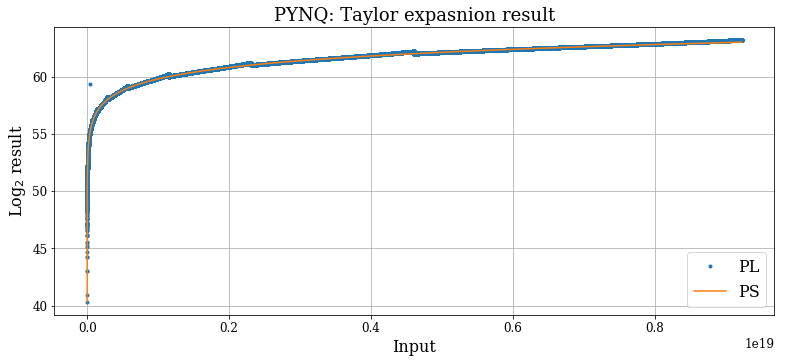

In [41]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))



plt.plot(input_value    ,out_pl      , '.', label="PL")
plt.plot(input_value_sort,out_ps_sort, '-', label="PS")
plt.title('PYNQ: Taylor expasnion result')
plt.xlabel('Input')
plt.ylabel('Log$_2$ result')
plt.grid(True)
plt.legend()

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_TE_res", bbox_inches='tight')
#######################################################################

plt.show()

In [42]:
error_a = (out_ps-out_pl)
error_r = (out_ps-out_pl)/out_ps

### Relative error distribution

In [43]:
# looking for errors
outlier   = np.where(np.abs(error_a)>5*np.std(error_a))
error_a_d = np.delete(error_a,outlier)
error_r_d = np.delete(error_r,outlier)
print("Find %d error/s" % np.shape(outlier)[0])
print(outlier)

Find 1 error/s
(array([75], dtype=int32),)


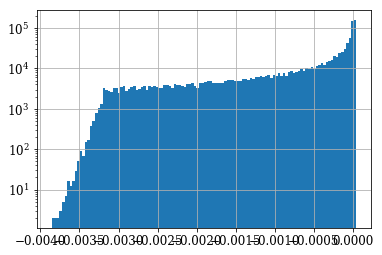

In [44]:
plt.hist(error_r_d,bins=120)
plt.semilogy()
plt.grid(True)
plt.show()

In [45]:
print("Mean relative error distribution               = %f " % np.mean(error_r_d))
print("Standard deviation relative error distribution = %f " % np.std(error_r_d))

Mean relative error distribution               = -0.000697 
Standard deviation relative error distribution = 0.000897 


### Absolute error distribution

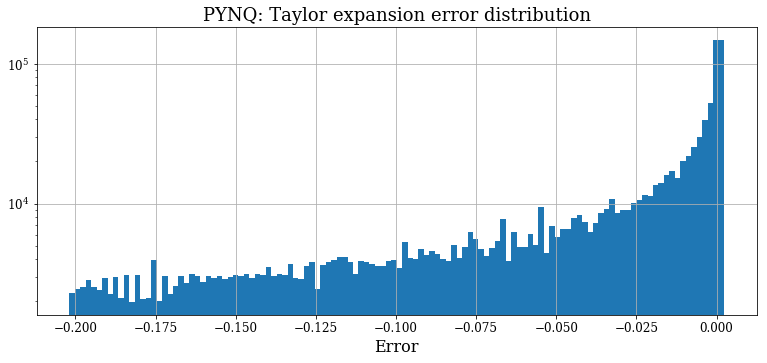

In [46]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)

#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

plt.hist(error_a_d,bins=120)
plt.title('PYNQ: Taylor expansion error distribution')
plt.xlabel('Error')
plt.semilogy()
plt.grid(True)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_TE_LOG_error", bbox_inches='tight')
#######################################################################

plt.show()

In [47]:
print("Mean absolute error distribution               = %f " % np.mean(error_a_d))
print("Standard deviation absolute error distribution = %f " % np.std(error_a_d))

Mean absolute error distribution               = -0.043071 
Standard deviation absolute error distribution = 0.055538 


In [25]:
time_pl_arr = []
for i in range(50):
    input_value = np.random.randint(1,2**63-1,n, dtype=np.uint64)
    # convert into int64
    input_value = input_value.astype(np.uint64)
    # load to the input buffer
    np.copyto(input_buffer,input_value)
    time_s=time.time()
    lut_dma.sendchannel.transfer(input_buffer)
    lut_dma.recvchannel.transfer(output_buffer)

    lut_dma.sendchannel.wait()
    lut_dma.recvchannel.wait()
    time_pl=time.time()-time_s
    time_pl_arr.append(time_pl)
time_pl = np.mean(time_pl_arr)
std_time_pl = np.std(time_pl_arr)
print(time_pl)

0.007325706481933594


In [49]:
#Conversion from fixed point to readable number
out_pl=output_buffer/(2**10)

In [9]:
time_ps_arr = []
for i in range(20):
    time_s=time.time()
    out_ps=np.log2(input_value)
    time_ps=time.time()-time_s
    time_ps_arr.append(time_ps)
time_ps = np.mean(time_ps_arr)
std_time_ps = np.std(time_ps_arr)
print(time_ps)

0.36203556060791015


In [26]:
print("%d input samples" % n)
print("PL computation time = %f+/-%f s" % (time_pl, std_time_pl))
print("PS computation time = %f+/-%f  s" % (time_ps, std_time_ps))
print("PL computation time per sample = %e+/-%e s" % (time_pl/n, std_time_pl/n))
print("PS computation time per sample = %e+/-%e s" % (time_ps/n, std_time_ps/n))
print("PL is %f times faster than the PS" % (time_ps/time_pl))

1048576 input samples
PL computation time = 0.007326+/-0.000070 s
PS computation time = 0.362376+/-0.000333  s
PL computation time per sample = 6.986338e-09+/-6.636384e-11 s
PS computation time per sample = 3.455884e-07+/-3.174239e-10 s
PL is 49.466316 times faster than the PS


In [52]:
input_value_sort = np.sort(input_value, kind='heapsort')
out_ps_sort      = np.sort(out_ps     , kind='heapsort')

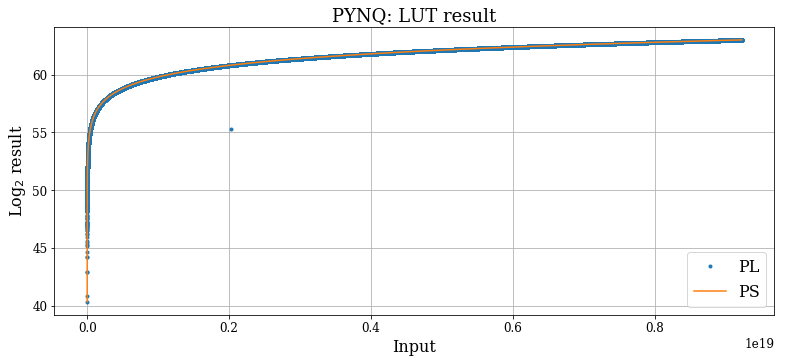

In [53]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))



plt.plot(input_value    ,out_pl      , '.', label="PL")
plt.plot(input_value_sort,out_ps_sort, '-', label="PS")
plt.title('PYNQ: LUT result')
plt.xlabel('Input')
plt.ylabel('Log$_2$ result')
plt.grid(True)
plt.legend()

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_LUT_res", bbox_inches='tight')
#######################################################################

plt.show()

In [54]:
error_a = (out_ps-out_pl)
error_r = (out_ps-out_pl)/out_ps

In [55]:
# looking for errors
outlier   = np.where(np.abs(error_a)>5*np.std(error_a))
error_a_d = np.delete(error_a,outlier)
error_r_d = np.delete(error_r,outlier)
print("Find %d error/s" % np.shape(outlier)[0])
print(outlier)

Find 1 error/s
(array([74], dtype=int32),)


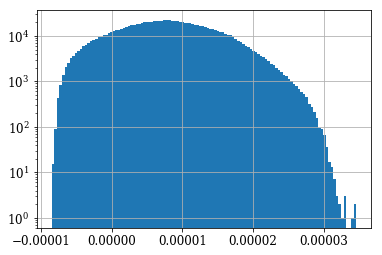

In [56]:
plt.hist(error_r_d,bins=120)
plt.semilogy()
plt.grid(True)
plt.show()

In [57]:
print("Mean relative error distribution               = %f " % np.mean(error_r_d))
print("Standard deviation relative error distribution = %f " % np.std(error_r_d))

Mean relative error distribution               = 0.000008 
Standard deviation relative error distribution = 0.000007 


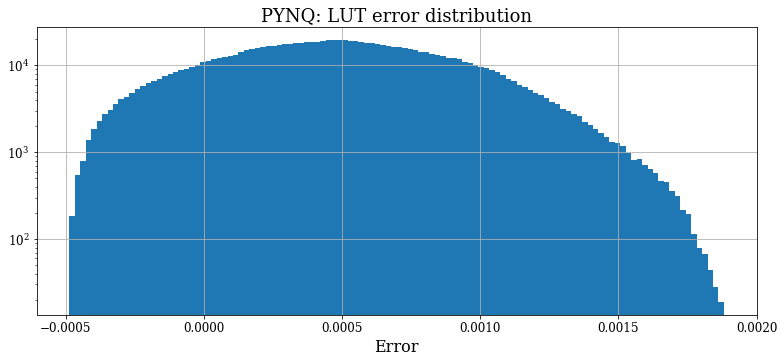

In [58]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)

#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

plt.hist(error_a_d,bins=120)
plt.title('PYNQ: LUT error distribution')
plt.xlabel('Error')
plt.semilogy()
plt.grid(True)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_LUT_LOG_error", bbox_inches='tight')
#######################################################################

plt.show()

In [59]:
print("Mean absolute error distribution               = %f " % np.mean(error_a_d))
print("Standard deviation absolute error distribution = %f " % np.std(error_a_d))

Mean absolute error distribution               = 0.000493 
Standard deviation absolute error distribution = 0.000413 
